### Import required libraries

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN, MNIST
from torchvision.transforms import Compose, Resize, Grayscale, ToTensor, Normalize
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import models

### load the pretrained ResNet18 model

In [ ]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Modify the final fully connected layer

In [ ]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

### Data transformations

In [ ]:
transform_svhn = Compose([
    ToTensor(),
    Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1201, 0.1231, 0.1052])
])


transform_mnist = Compose([
    Resize((32, 32)),
    Grayscale(num_output_channels=3),
    ToTensor(),
    Normalize(mean=[0.1307, 0.1307, 0.1307], std=[0.3015, 0.3015, 0.3015])
])

### loading the datasets

In [ ]:
train_dataset_svhn = SVHN(root='./data', split='train', download=True, transform=transform_svhn)
test_dataset_svhn = SVHN(root='./data', split='test', download=True, transform=transform_svhn)

train_loader_svhn = DataLoader(dataset=train_dataset_svhn, batch_size=16, shuffle=True, num_workers=2)
test_loader_svhn = DataLoader(dataset=test_dataset_svhn, batch_size=16, shuffle=False, num_workers=2)

train_dataset_mnist = MNIST(root='./data', train=True, download=True, transform=transform_mnist)
test_dataset_mnist = MNIST(root='./data', train=False, download=True, transform=transform_mnist)

train_loader_mnist = DataLoader(dataset=train_dataset_mnist, batch_size=16, shuffle=True, num_workers=2)
test_loader_mnist = DataLoader(dataset=test_dataset_mnist, batch_size=16, shuffle=False, num_workers=2)

print("Data loaders have been created.")

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Data loaders have been created.


###  Initialize the Model, Loss Function, and Optimizer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
criterion = nn.CrossEntropyLoss()

###  Fine-tune the model on the SVHN dataset

In [ ]:
num_epochs = 10
losses = []

for epoch in tqdm(range(num_epochs), desc='Training Epochs'):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader_svhn:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader_svhn)
    losses.append(epoch_loss)
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {100.*correct/total:.2f}%')

Training Epochs:  10%|█         | 1/10 [01:32<13:49, 92.14s/it]

Epoch 1/10, Training Loss: 0.6890, Training Accuracy: 79.64%


Training Epochs:  20%|██        | 2/10 [02:59<11:56, 89.53s/it]

Epoch 2/10, Training Loss: 0.3800, Training Accuracy: 89.30%


Training Epochs:  30%|███       | 3/10 [04:27<10:20, 88.71s/it]

Epoch 3/10, Training Loss: 0.2950, Training Accuracy: 91.60%


Training Epochs:  40%|████      | 4/10 [06:00<09:01, 90.28s/it]

Epoch 4/10, Training Loss: 0.2414, Training Accuracy: 93.12%


Training Epochs:  50%|█████     | 5/10 [07:28<07:26, 89.36s/it]

Epoch 5/10, Training Loss: 0.2046, Training Accuracy: 94.12%


Training Epochs:  60%|██████    | 6/10 [08:56<05:56, 89.08s/it]

Epoch 6/10, Training Loss: 0.1698, Training Accuracy: 95.17%


Training Epochs:  70%|███████   | 7/10 [10:25<04:27, 89.01s/it]

Epoch 7/10, Training Loss: 0.1426, Training Accuracy: 95.90%


Training Epochs:  80%|████████  | 8/10 [11:54<02:58, 89.09s/it]

Epoch 8/10, Training Loss: 0.1227, Training Accuracy: 96.47%


Training Epochs:  90%|█████████ | 9/10 [13:22<01:28, 88.70s/it]

Epoch 9/10, Training Loss: 0.1020, Training Accuracy: 97.01%


Training Epochs: 100%|██████████| 10/10 [14:50<00:00, 89.09s/it]

Epoch 10/10, Training Loss: 0.0867, Training Accuracy: 97.47%


### plotting the loss

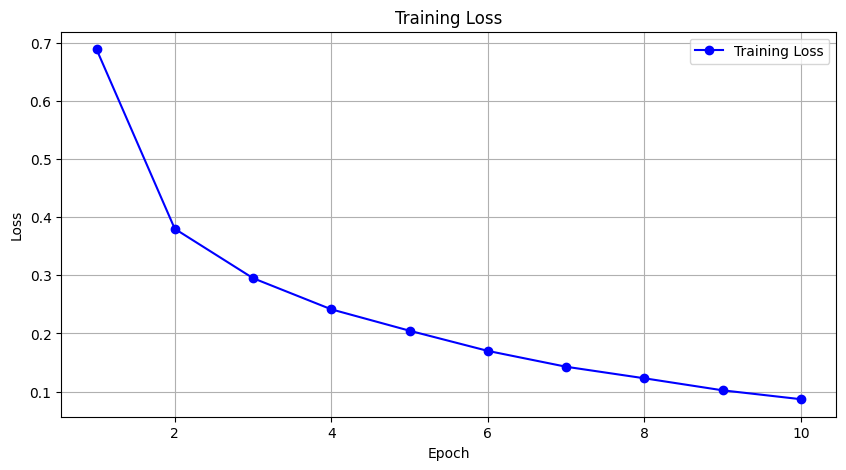

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o', color='blue', label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

### Define Testing model

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

### Test the fine-tuned model on both the SVHN and MNIST datasets

In [ ]:
accuracy_svhn = test_model(model, test_loader_svhn)
accuracy_mnist = test_model(model, test_loader_mnist)

Accuracy: 93.60%
Accuracy: 72.23%
